In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from setproctitle import setproctitle
setproctitle("ENRICO_TIME")

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-08-02 22:43:54.819090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 22:43:55.750207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-02 22:43:57.493774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-02 22:43:57.558439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
from tqdm import trange
from UltimateTicTacToeEnvSelfPlay import UltimateTicTacToeEnvSelfPlay
from DQNAgent import DQNAgent
from A2CAgent import A2CAgent
from DoubleDQNAgent import DoubleDQNAgent
from PPOAgent import PPOAgent
from Stopwatch import Stopwatch

Setup of parameters

In [6]:
TRAINING_DURATION = 3600 # in seconds
ASSESSMENT_INTERVAL = 60  # in seconds
GAMES = 128

# DQN

In [7]:
def asses_performance_dqn(agent):
    NUM_OF_GAMES = 1000
    performance_envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(NUM_OF_GAMES)]
    dones = np.zeros((NUM_OF_GAMES,), dtype=bool)
    final_rewards = np.zeros((NUM_OF_GAMES,))
    while(not np.all(dones) != 0):
        performance_states = np.array([env.to_state()[0] for env in performance_envs])
        performance_available_actions = np.array([env.to_state()[1] for env in performance_envs])
        performance_actions = agent.choose_action(performance_states, performance_available_actions, True)
        performance_r1 = np.zeros(NUM_OF_GAMES)
        game_finished = np.zeros(NUM_OF_GAMES)
        for i in range(NUM_OF_GAMES):
          if dones[i] == True:
            continue
          _, performance_r1[i], game_finished[i], _  = performance_envs[i].step(performance_actions[i])
          if game_finished[i] == True:
              dones[i] = True
              final_rewards[i] = performance_r1[i]

        states_opponent = np.array([env.to_state()[0] for env in performance_envs])
        available_actions_opponent = np.array([env.to_state()[1] for env in performance_envs])
        actions_opponent = np.full(available_actions_opponent.shape[0], -1, dtype=int)
        one_indices = available_actions_opponent == 1
        # For each row where there is at least one '1', select a random index of '1'
        for i in range(available_actions_opponent.shape[0]):
            valid_indices = np.where(one_indices[i])[0]
            if valid_indices.size > 0:
                actions_opponent[i] = np.random.choice(valid_indices)
        performance_r2 = np.zeros(NUM_OF_GAMES)
        game_finished = np.zeros(NUM_OF_GAMES)
        for i in range(NUM_OF_GAMES):
              if dones[i] == True:
                continue
              _, performance_r2[i], game_finished[i], _  = performance_envs[i].step(actions_opponent[i])
              if game_finished[i] == True:
                  dones[i] = True
                  final_rewards[i] = -performance_r2[i]

    return np.count_nonzero(final_rewards == 1)/len(dones), np.count_nonzero(final_rewards == 0)/len(dones)

In [8]:
# Initialize the Agent
DQN_rewards = []
envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(GAMES)]
state_space_shape = envs[0].to_state()[0].shape
action_space_size = 81
agent = DQNAgent(action_space_size, state_space_shape, exploration_rate=1.0)

performance_dqn = []
draws_dqn = []
performance_with_draws_dqn = []

performance_dqn_time = []
draws_dqn_time = []
performance_with_draws_dqn_time = []

states = np.array([env.to_state()[0] for env in envs])
available_actions = np.array([env.to_state()[1] for env in envs])
actions = agent.choose_action(states, available_actions)
r1 = np.zeros(GAMES)
exploration_rate_history = []
for i in range(GAMES):
    r1[i] = envs[i].step(actions[i])[1]

initial_exploration_rate = 1.0
final_exploration_rate = 0.05
exploration_decay_rate = (initial_exploration_rate - final_exploration_rate) / (TRAINING_DURATION * 0.8)

stopwatch = Stopwatch()
next_assessment_time = stopwatch.now() + ASSESSMENT_INTERVAL
stopwatch.start()

episode = 0

# Training Loop
while True:

    if len(performance_dqn_time) == TRAINING_DURATION/ASSESSMENT_INTERVAL:
        break

    if episode % 100 == 0:
        stopwatch.pause()
        win, draw = asses_performance_dqn(agent)
        performance_dqn.append(win)
        draws_dqn.append(draw)
        performance_with_draws_dqn.append(win+draw)
        stopwatch.start()

    if stopwatch.now() >= next_assessment_time:
        stopwatch.pause()
        win, draw = asses_performance_dqn(agent)
        performance_dqn_time.append(win)
        draws_dqn_time.append(draw)
        performance_with_draws_dqn_time.append(win+draw)
        next_assessment_time = next_assessment_time + ASSESSMENT_INTERVAL
        stopwatch.start()

    states_opponent = np.array([env.to_state()[0] for env in envs])
    available_actions_opponent = np.array([env.to_state()[1] for env in envs])
    actions_opponent = agent.choose_action(states_opponent, available_actions_opponent)
    r2 = np.zeros(GAMES)
    dones = np.zeros(GAMES, dtype=bool)
    for i in range(GAMES):
        _, r2[i], dones[i], _ = envs[i].step(actions_opponent[i])
    rewards = r1 - r2
    DQN_rewards.append(np.average(rewards))
    next_states = np.array([env.to_state()[0] for env in envs])
    next_states_available_actions = np.array([env.to_state()[1] for env in envs])

    agent.update_q_values(states, actions, rewards, next_states, dones, next_states_available_actions)

    if agent.exploration_rate > final_exploration_rate:
        agent.set_exploration_rate(agent.exploration_rate - exploration_decay_rate)
    exploration_rate_history.append(agent.exploration_rate)

    states = states_opponent
    available_actions = available_actions_opponent
    actions = actions_opponent
    r1 = r2

    episode = episode + 1

2024-08-02 22:43:58.580946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-02 22:43:58.581272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-02 22:43:58.581506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

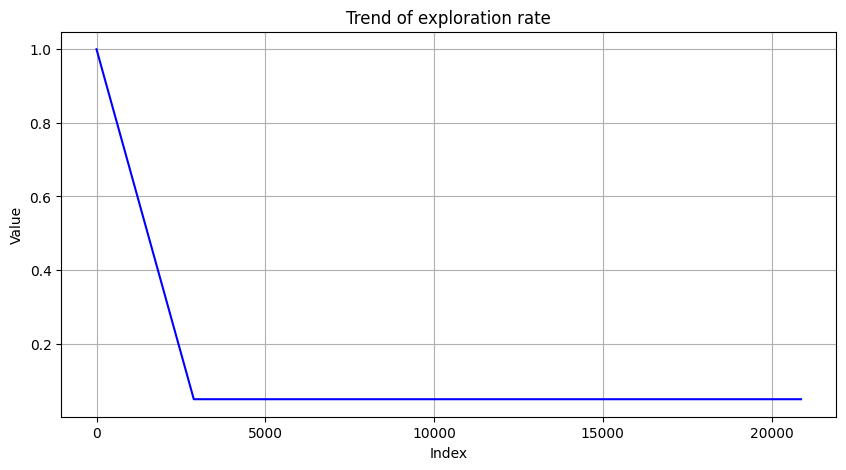

In [9]:
import matplotlib.pyplot as plt

# Creating a trend chart
plt.figure(figsize=(10, 5))
plt.plot(exploration_rate_history, linestyle='-', color='b')
plt.title('Trend of exploration rate')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Double DQN

In [10]:
import time

# Initialize the Agent
DQN_rewards = []
envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(GAMES)]
state_space_shape = envs[0].to_state()[0].shape
action_space_size = 81
agent = DoubleDQNAgent(action_space_size, state_space_shape, exploration_rate=0.8, target_update_frequency=20)

performance_double_dqn = []
draws_double_dqn = []
performance_with_draws_double_dqn = []

performance_double_dqn_time = []
draws_double_dqn_time = []
performance_with_draws_double_dqn_time = []

states = np.array([env.to_state()[0] for env in envs])
available_actions = np.array([env.to_state()[1] for env in envs])
actions = agent.choose_action(states, available_actions)
r1 = np.zeros(GAMES)
exploration_rate_history = []
for i in range(GAMES):
    r1[i] = envs[i].step(actions[i])[1]

initial_exploration_rate = 1.0
final_exploration_rate = 0.05
exploration_decay_rate = (initial_exploration_rate - final_exploration_rate) / (TRAINING_DURATION * 0.8)

stopwatch = Stopwatch()
next_assessment_time = stopwatch.now() + ASSESSMENT_INTERVAL
stopwatch.start()

episode = 0

# Training Loop
while True:

    if len(performance_double_dqn_time) == TRAINING_DURATION/ASSESSMENT_INTERVAL:
        break

    if episode % 100 == 0:
        stopwatch.pause()
        win, draw = asses_performance_dqn(agent)
        performance_double_dqn.append(win)
        draws_double_dqn.append(draw)
        performance_with_draws_double_dqn.append(win+draw)
        stopwatch.start()

    if stopwatch.now() >= next_assessment_time:
        stopwatch.pause()
        win, draw = asses_performance_dqn(agent)
        performance_double_dqn_time.append(win)
        draws_double_dqn_time.append(draw)
        performance_with_draws_double_dqn_time.append(win+draw)
        next_assessment_time = next_assessment_time + ASSESSMENT_INTERVAL
        stopwatch.start()

    states_opponent = np.array([env.to_state()[0] for env in envs])
    available_actions_opponent = np.array([env.to_state()[1] for env in envs])
    actions_opponent = agent.choose_action(states_opponent, available_actions_opponent)
    r2 = np.zeros(GAMES)
    dones = np.zeros(GAMES, dtype=bool)
    for i in range(GAMES):
        _, r2[i], dones[i], _ = envs[i].step(actions_opponent[i])
    rewards = r1 - r2
    DQN_rewards.append(np.average(rewards))
    next_states = np.array([env.to_state()[0] for env in envs])
    next_states_available_actions = np.array([env.to_state()[1] for env in envs])

    agent.update_q_values(states, actions, rewards, next_states, dones, next_states_available_actions, episode)

    if agent.exploration_rate > final_exploration_rate:
        agent.set_exploration_rate(agent.exploration_rate - exploration_decay_rate)
    exploration_rate_history.append(agent.exploration_rate)

    states = states_opponent
    actions = actions_opponent
    r1 = r2

    episode = episode + 1

# A2C

In [11]:
def asses_performance_a2c(agent):
    NUM_OF_GAMES = 128
    performance_envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(NUM_OF_GAMES)]
    dones = np.zeros((NUM_OF_GAMES,), dtype=bool)
    final_rewards = np.zeros((NUM_OF_GAMES,))
    while(not np.all(dones) != 0):
        performance_states = np.array([env.to_state()[0] for env in performance_envs])
        performance_available_actions = np.array([env.to_state()[1] for env in performance_envs])
        performance_actions = agent.act(performance_states, performance_available_actions)
        performance_r1 = np.zeros(NUM_OF_GAMES)
        game_finished = np.zeros(NUM_OF_GAMES)
        for i in range(NUM_OF_GAMES):
          if dones[i] == True:
            continue
          _, performance_r1[i], game_finished[i], _  = performance_envs[i].step(performance_actions[i])
          if game_finished[i] == True:
              dones[i] = True
              final_rewards[i] = performance_r1[i]

        states_opponent = np.array([env.to_state()[0] for env in performance_envs])
        available_actions_opponent = np.array([env.to_state()[1] for env in performance_envs])
        actions_opponent = np.full(available_actions_opponent.shape[0], -1, dtype=int)
        one_indices = available_actions_opponent == 1
        # For each row where there is at least one '1', select a random index of '1'
        for i in range(available_actions_opponent.shape[0]):
            valid_indices = np.where(one_indices[i])[0]
            if valid_indices.size > 0:
                actions_opponent[i] = np.random.choice(valid_indices)
        performance_r2 = np.zeros(NUM_OF_GAMES)
        game_finished = np.zeros(NUM_OF_GAMES)
        for i in range(NUM_OF_GAMES):
              if dones[i] == True:
                continue
              _, performance_r2[i], game_finished[i], _  = performance_envs[i].step(actions_opponent[i])
              if game_finished[i] == True:
                  dones[i] = True
                  final_rewards[i] = -performance_r2[i]

    return np.count_nonzero(final_rewards == 1)/len(dones), np.count_nonzero(final_rewards == 0)/len(dones)

In [12]:
import time

# Initialize the Agent
GAMES = 128
DQN_rewards = []
envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(GAMES)]
state_space_shape = envs[0].to_state()[0].shape
action_space_size = 81

agent = A2CAgent(state_space_shape, action_space_size)

performance_a2c = []
draws_a2c = []
performance_with_draws_a2c = []

performance_a2c_time = []
draws_a2c_time = []
performance_with_draws_a2c_time = []

states = np.array([env.to_state()[0] for env in envs])
available_actions = np.array([env.to_state()[1] for env in envs])
actions = agent.act(states, available_actions)
r1 = np.zeros(GAMES)
for i in range(GAMES):
    r1[i] = envs[i].step(actions[i])[1]

stopwatch = Stopwatch()
next_assessment_time = stopwatch.now() + ASSESSMENT_INTERVAL
stopwatch.start()

episode = 0

# Training Loop
while True:

    if len(performance_a2c_time) == TRAINING_DURATION/ASSESSMENT_INTERVAL:
        break

    if episode % 100 == 0:
        stopwatch.pause()
        win, draw = asses_performance_a2c(agent)
        performance_a2c.append(win)
        draws_a2c.append(draw)
        performance_with_draws_a2c.append(win+draw)
        stopwatch.start()

    if stopwatch.now() >= next_assessment_time:
        stopwatch.pause()
        win, draw = asses_performance_a2c(agent)
        performance_a2c_time.append(win)
        draws_a2c_time.append(draw)
        performance_with_draws_a2c_time.append(win+draw)
        next_assessment_time = next_assessment_time + ASSESSMENT_INTERVAL
        stopwatch.start()

    states_opponent = np.array([env.to_state()[0] for env in envs])
    available_actions_opponent = np.array([env.to_state()[1] for env in envs])
    actions_opponent = agent.act(states_opponent, available_actions_opponent)
    r2 = np.zeros(GAMES)
    dones = np.zeros(GAMES, dtype=bool)
    for i in range(GAMES):
        _, r2[i], dones[i], _ = envs[i].step(actions_opponent[i])
    rewards = r1 - r2
    DQN_rewards.append(np.average(rewards))
    next_states = np.array([env.to_state()[0] for env in envs])
    next_states_available_actions = np.array([env.to_state()[1] for env in envs])

    agent.train(states, actions, rewards, next_states, dones, available_actions)

    states = states_opponent
    actions = actions_opponent
    available_actions = available_actions_opponent
    r1 = r2

    episode = episode + 1

# PPO

In [13]:
# Initialize the Agent
GAMES = 128
ITERATIONS = 10000
envs = [UltimateTicTacToeEnvSelfPlay() for _ in range(GAMES)]
state_space_shape = envs[0].to_state()[0].shape
action_space_size = 81

agent = PPOAgent(state_space_shape, action_space_size)

performance_ppo = []
draws_ppo = []
performance_with_draws_ppo = []

performance_ppo_time = []
draws_ppo_time = []
performance_with_draws_ppo_time = []

states = np.array([env.to_state()[0] for env in envs])
available_actions = np.array([env.to_state()[1] for env in envs])
actions = agent.act(states, available_actions)
r1 = np.zeros(GAMES)
for i in range(GAMES):
    r1[i] = envs[i].step(actions[i])[1]

stopwatch = Stopwatch()
next_assessment_time = stopwatch.now() + ASSESSMENT_INTERVAL
stopwatch.start()

episode = 0

# Training Loop
while True:

    if len(performance_ppo_time) == TRAINING_DURATION/ASSESSMENT_INTERVAL:
        break

    if episode % 100 == 0:
        stopwatch.pause()
        win, draw = asses_performance_a2c(agent)
        performance_ppo.append(win)
        draws_ppo.append(draw)
        performance_with_draws_ppo.append(win+draw)
        stopwatch.start()

    if stopwatch.now() >= next_assessment_time:
        stopwatch.pause()
        win, draw = asses_performance_a2c(agent)
        performance_ppo_time.append(win)
        draws_ppo_time.append(draw)
        performance_with_draws_ppo_time.append(win+draw)
        next_assessment_time = next_assessment_time + ASSESSMENT_INTERVAL
        stopwatch.start()

    states_opponent = np.array([env.to_state()[0] for env in envs])
    available_actions_opponent = np.array([env.to_state()[1] for env in envs])
    actions_opponent = agent.act(states_opponent, available_actions_opponent)
    r2 = np.zeros(GAMES)
    dones = np.zeros(GAMES, dtype=bool)
    for i in range(GAMES):
        _, r2[i], dones[i], _ = envs[i].step(actions_opponent[i])
    rewards = r1 - r2
    next_states = np.array([env.to_state()[0] for env in envs])
    next_states_available_actions = np.array([env.to_state()[1] for env in envs])

    agent.train(states, actions, rewards, next_states, dones, available_actions)

    states = states_opponent
    actions = actions_opponent
    available_actions = available_actions_opponent
    r1 = r2

    episode = episode + 1

# Results

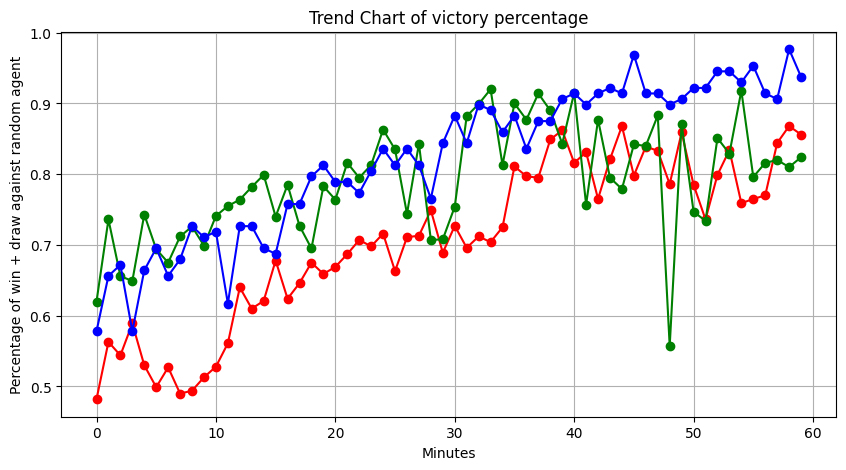

: 

In [18]:
import matplotlib.pyplot as plt

# Creating a trend chart
plt.figure(figsize=(10, 5))
plt.plot(performance_with_draws_dqn_time, marker='o', linestyle='-', color='r')
plt.plot(performance_with_draws_double_dqn_time, marker='o', linestyle='-', color='g')
plt.plot(performance_with_draws_a2c_time, marker='o', linestyle='-', color='b')
# plt.plot(performance_with_draws_ppo_time, marker='o', linestyle='-', color='c')
plt.title('Trend Chart of victory percentage')
plt.xlabel('Minutes')
plt.ylabel('Percentage of win + draw against random agent')
plt.grid(True)
plt.show()